# Clustering and Visualization on Fish Data

The data is from Kaggle and is called Fish market: Database of common fish species for fish market.

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from matplotlib import pyplot as plt
import seaborn as sns
import time
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import time
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import random

In [2]:
fish_df = pd.read_csv('Fish.csv') # load the data

In [3]:
fish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
Species    159 non-null object
Weight     159 non-null float64
Length1    159 non-null float64
Length2    159 non-null float64
Length3    159 non-null float64
Height     159 non-null float64
Width      159 non-null float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


No missing data. The dataset is quite small, containing only 159 entries.

In [4]:
fish_df.head() # take a peak

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


There a are six numeric columns:

Weight: weight of fish in g<br>
Length1: vertical length in cm<br>
Length2: diagonal length in cm<br>
Length3: cross length in cm<br>
Height: height in cm<br>
Width: diagonal width in cm<br>

The first column, Species, is categorical.

In [5]:
fish_df['Species'].value_counts()

Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: Species, dtype: int64

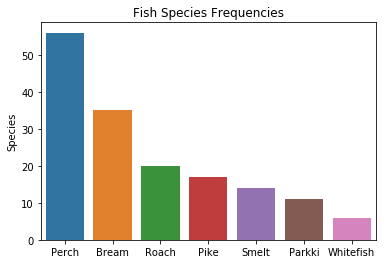

In [6]:
sns.barplot(x=fish_df['Species'].value_counts().index,y=fish_df['Species'].value_counts()).set_title('Fish Species Frequencies')
plt.show()

There are seven species of fish. It will be interesting to see if clustering techniques can find the seven clusters.

Due to the dearth of data, it would be interesting to see how well a supervised learning algorithm could identify these species. This could manage our expectations for the unsupervised techniques.

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [8]:
X = fish_df.iloc[:,1:]
y = fish_df['Species']

Train some untuned models to get a sense of how well the features can determine the species.

In [9]:
import warnings
warnings.filterwarnings('ignore')

for model in [KNeighborsClassifier(),
             LinearSVC(),
             LogisticRegression(),
             RandomForestClassifier()]:
    print(str(type(model)).split('.')[-1].strip("'>") + ': ')
    print(cross_val_score(model,X,y,cv=5))
    print()

KNeighborsClassifier: 
[0.28571429 0.46875    0.32258065 0.41935484 0.4       ]

LinearSVC: 
[0.65714286 0.5        0.4516129  0.58064516 0.53333333]

LogisticRegression: 
[0.91428571 0.9375     0.96774194 0.96774194 0.8       ]

RandomForestClassifier: 
[0.31428571 0.59375    0.58064516 0.61290323 0.46666667]



Logistic Regression can usually identify the correct species with over 90% accuracy so there is definitely some signal there.

Next let's visualize the data with pca, t-sne, and umap without standardization.

In [10]:
t0 = time.time()
X_pca = PCA(n_components=2).fit_transform(X)
t1 = time.time()
X_tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(X)
t2 = time.time()
X_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation').fit_transform(X)
t3 = time.time()
print('pca: {}'.format(t1-t0))
print('t-sne: {}'.format(t2-t1))
print('umap: {}'.format(t3-t2))

pca: 0.001994609832763672
t-sne: 0.5973944664001465
umap: 7.713154554367065


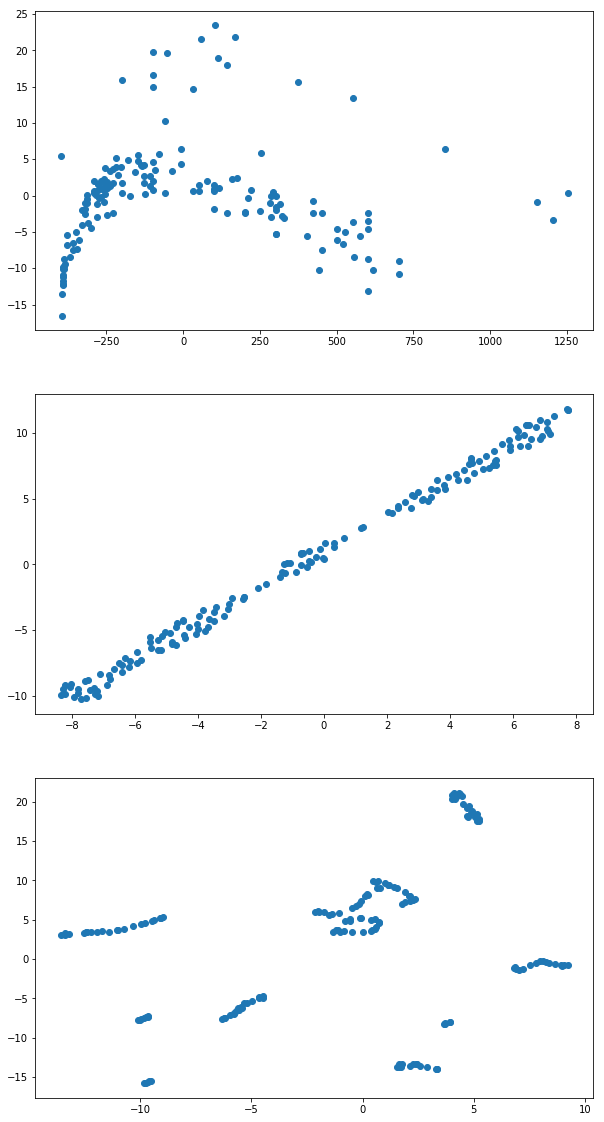

In [11]:
fig, axes = plt.subplots(3,1,figsize=(10,20))
axes[0].scatter(X_pca[:,0],X_pca[:,1])
axes[1].scatter(X_tsne[:,0],X_tsne[:,1])
axes[2].scatter(X_umap[:,0],X_umap[:,1])
plt.show()

Each technique produces quite a distinct image. PCA makes a nonlinear hook with some spray eminating off. T-SNE makes a straight line of variable thickness. UMAP makes tiny cluster amoebas.

Let's now standardize the data set with sklearn's standard scalar and reapply the dimensionality reduction algorithms.

In [12]:
X_std = StandardScaler().fit_transform(X)
X_std_pca = PCA(n_components=2).fit_transform(X_std)
X_std_tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(X_std)
X_std_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation').fit_transform(X_std)

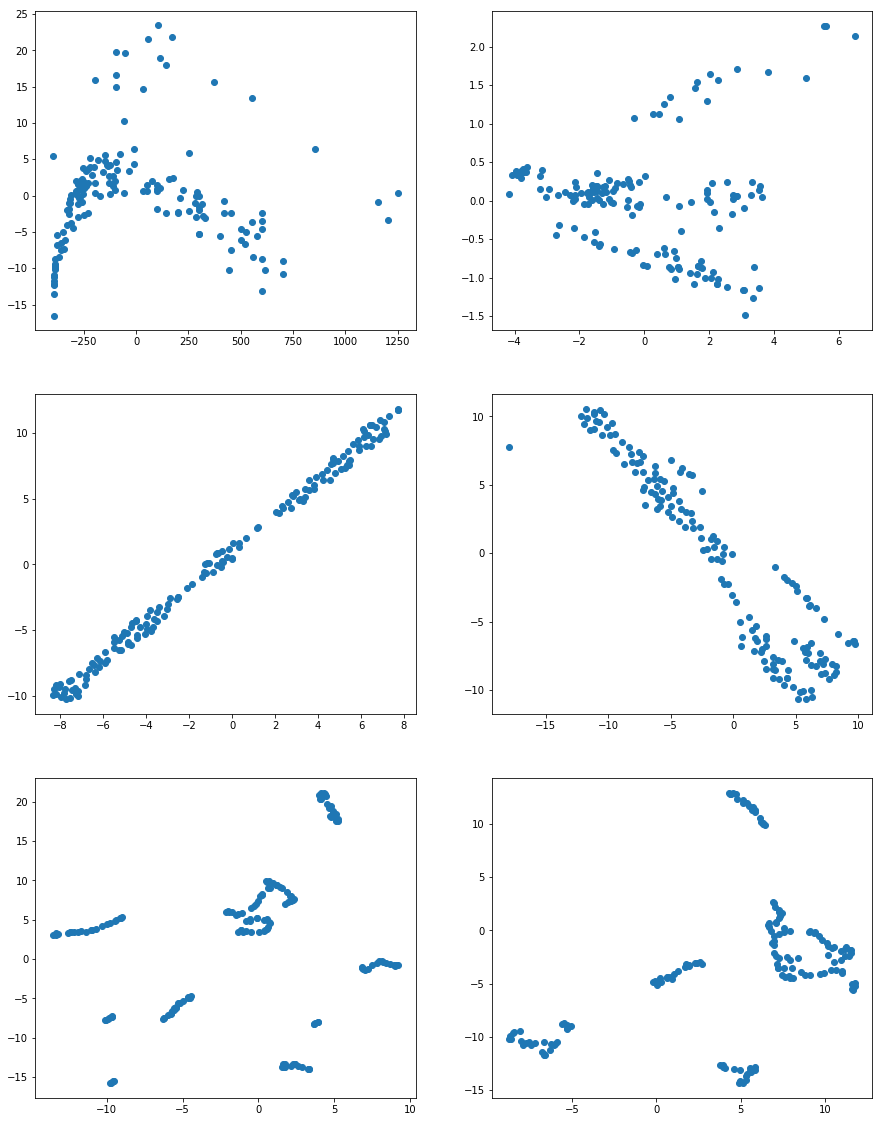

In [13]:
fig, axes = plt.subplots(3,2,figsize=(15,20))
axes[0,0].scatter(X_pca[:,0],X_pca[:,1])
axes[0,1].scatter(X_std_pca[:,0],X_std_pca[:,1])
axes[1,0].scatter(X_tsne[:,0],X_tsne[:,1])
axes[1,1].scatter(X_std_tsne[:,0],X_std_tsne[:,1])
axes[2,0].scatter(X_umap[:,0],X_umap[:,1])
axes[2,1].scatter(X_std_umap[:,0],X_std_umap[:,1])
plt.show()

T-SNE and PCA are now producing more pronounced clusters. Yes, I do realize that these are not clustering techniques, but it seems there utility comes from being able to view clusters in unlabeled data.

With this dataset, though, we have the benefit of labels. This makes it a supervised learning task, but it also allows us to use unsupervised learning techniques and then peak behind the curtain. Let's do just that.

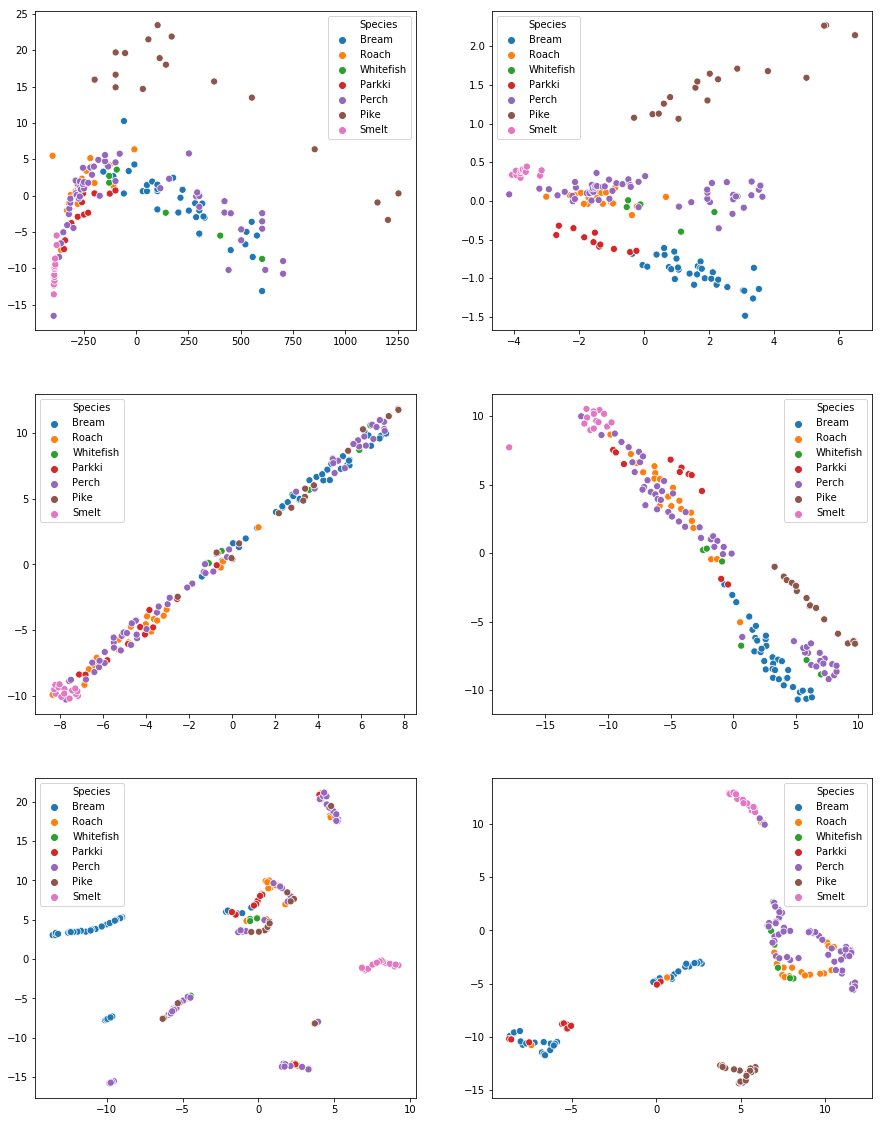

In [14]:
fig, axes = plt.subplots(3,2,figsize=(15,20))
sns.scatterplot(X_pca[:,0],X_pca[:,1],ax=axes[0,0],s=50,hue=y)
sns.scatterplot(X_std_pca[:,0],X_std_pca[:,1],ax=axes[0,1],s=50,hue=y)
sns.scatterplot(X_tsne[:,0],X_tsne[:,1],ax=axes[1,0],s=50,hue=y)
sns.scatterplot(X_std_tsne[:,0],X_std_tsne[:,1],ax=axes[1,1],s=50,hue=y)
sns.scatterplot(X_umap[:,0],X_umap[:,1],ax=axes[2,0],s=50,hue=y)
sns.scatterplot(X_std_umap[:,0],X_std_umap[:,1],ax=axes[2,1],s=50,hue=y)
plt.show()

This provides good empirical support for feature standardization. PCA and T-SNE are beginning to separate the data into some species clusters. UMAP is just kind of doing its own thing.

Next step: apply some clustering algorithms and see if their results coincide with fish species.

## K-means
I'm not terribly optimistic about the performance of K-means on this data. The algorithm works best isotropic data, and the PCA projection (the only visualization that preserves shape in some sense due to its linearity) looks more like streaks than balls.

The main hyperparameter to tune is the number of clusters we want. Of course, we know there are seven species, but remember, we're pretending we don't know this (unsupervised learning), and then, with the benefit of labels, checking how we would have.

In [15]:
random.seed(123)
m = X_std.shape[0]
random_half1 = sorted(random.sample(range(m),m//2))
random_half2 = list(set(range(m)) - set(random_half1))

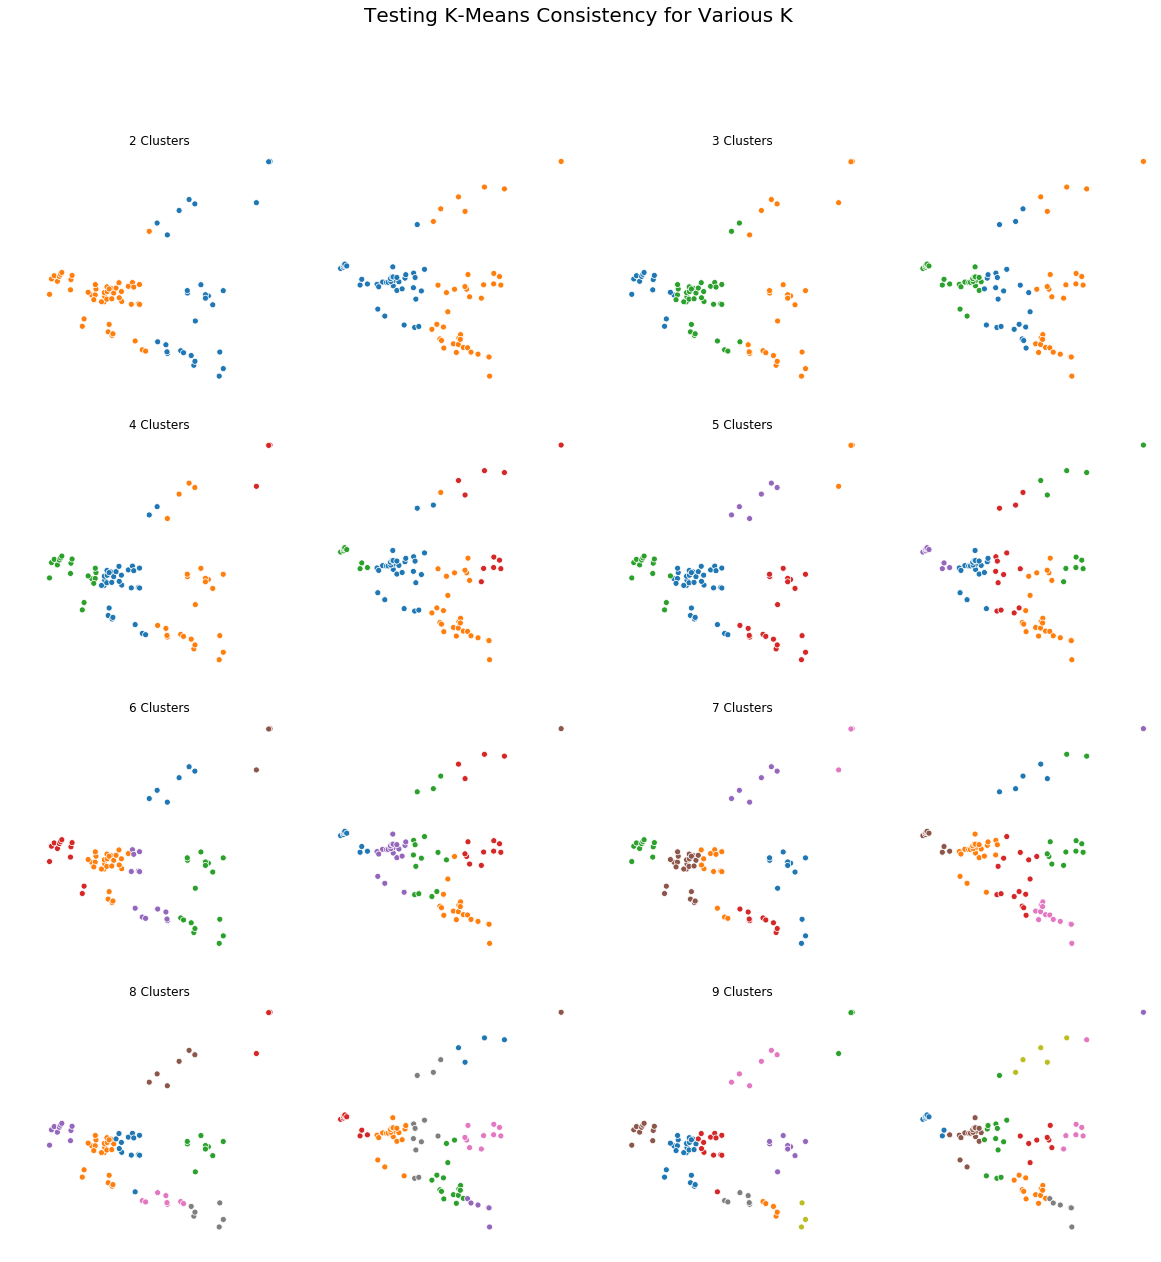

In [16]:
colors = sns.color_palette()
fig, axes = plt.subplots(4,4,figsize=(20,20))
fig.suptitle('Testing K-Means Consistency for Various K',fontsize=20)
for k in range(2,10):
    y_pred1 = KMeans(n_clusters=k, random_state=123).fit_predict(X_std[random_half1])
    y_pred2 = KMeans(n_clusters=k, random_state=123).fit_predict(X_std[random_half2])
    i, j = (k-2)//2, 2*k%4 #indices of axis on which to plot
    ax1 = ax=axes[i,j] #axes on which to plot first half of points
    ax2 = axes[i,j+1] #axes on which to plot second half
    sns.scatterplot(X_std_pca[random_half1,0],X_std_pca[random_half1,1],hue=y_pred1,ax=ax1,palette=colors[:k])
    sns.scatterplot(X_std_pca[random_half2,0],X_std_pca[random_half2,1],hue=y_pred2,ax=ax2,palette=colors[:k])
    ax1.axis('off')
    ax2.axis('off')
    ax1.get_legend().remove()
    ax2.get_legend().remove()
    ax1.set_title('{} Clusters'.format(k))

Next, let's evaluate the quality of the clusters produced by k-means as a function of k. We will use <a href='https://en.wikipedia.org/wiki/Silhouette_(clustering)'>Silhouettes</a> to evaluate the clusters had we not had labels, and <a href='https://en.wikipedia.org/wiki/Rand_index'>Adjusted Rand Index</a> to evaluate them with respect to the correct labels.

In [17]:
y_preds= []
for k in range(2,15):
    y_preds.append(KMeans(n_clusters=k, random_state=123).fit_predict(X_std))

In [18]:
silhouette_scores=[]
for i in range(len(y_preds)):
    silhouette_scores.append(metrics.silhouette_score(X_std, y_preds[i], metric='euclidean'))

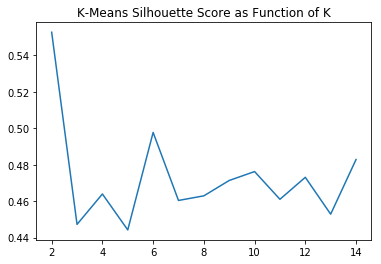

In [19]:
plt.plot(list(range(2,15)),silhouette_scores)
plt.title('K-Means Silhouette Score as Function of K')
plt.show()

Two interesting features: the global maximum at k=2 and the local maximum at k=6. We visualize these two clusterings using PCA. Let's also plot k=7 to see how k-means does when we know the correct number of clusters. The marker shape will denote the cluster a point belongs to and the color will give the correct species. We should keep in mind that we're projecting 6 dimensional data to the plane, so overlapping points may not be close.

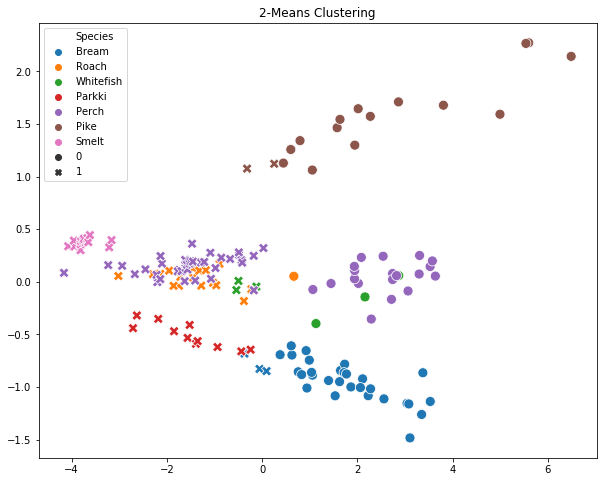

In [20]:
# Future task: learn how to remove items from legend.
plt.figure(figsize=(10,8))
sns.scatterplot(X_std_pca[:,0],X_std_pca[:,1],hue=y,style=y_preds[0],s=100)
plt.title('2-Means Clustering')
plt.show()

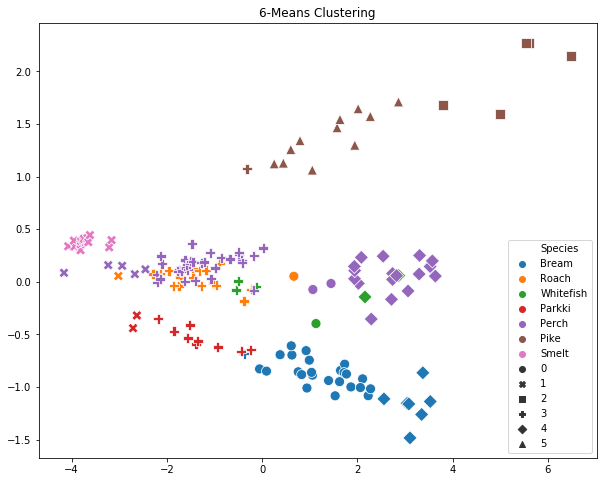

In [21]:
plt.figure(figsize=(10,8))
sns.scatterplot(X_std_pca[:,0],X_std_pca[:,1],hue=y,style=y_preds[4],s=100)
plt.title('6-Means Clustering')
plt.show()

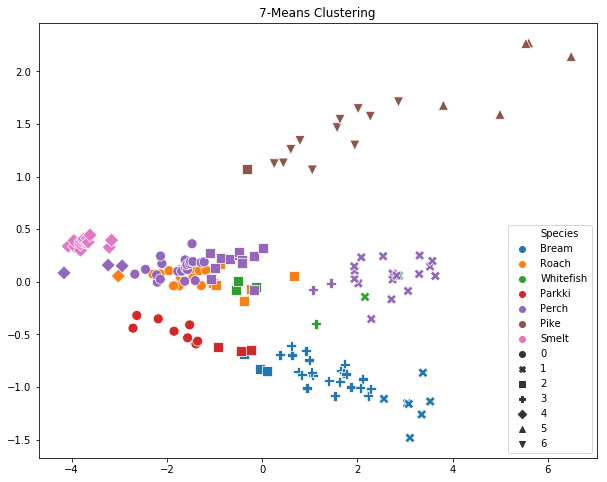

In [22]:
plt.figure(figsize=(10,8))
sns.scatterplot(X_std_pca[:,0],X_std_pca[:,1],hue=y,style=y_preds[5],s=100)
plt.title('7-Means Clustering')
plt.show()

None of these options are really satisfactory. We anticipated this as k-means likes isotropic data. When we move from k=6 to k=7, the roach/pearch mix (purple and orange) get divided in a way that doesn't really correspond to the species, so it only made things worse.

Humans like pictures, but let's make our analysis more rigorous be computing the adjusted Rand index for each k and compare with silouettes.

In [23]:
adj_rand_scores=[]
for i in range(len(y_preds)):
    adj_rand_scores.append(metrics.adjusted_rand_score(y, y_preds[i]))

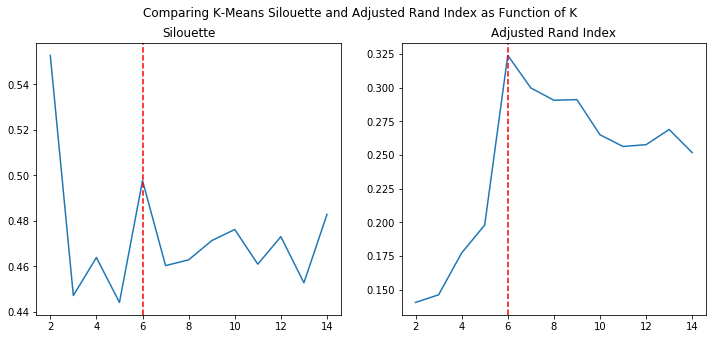

In [24]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
axes[0].plot(list(range(2,15)),silhouette_scores)
axes[0].axvline(6,0,1,ls='--',c='r')
axes[0].set_title('Silouette')
axes[1].plot(list(range(2,15)),adj_rand_scores)
axes[1].axvline(6,0,1,ls='--',c='r')
axes[1].set_title('Adjusted Rand Index')
fig.suptitle('Comparing K-Means Silouette and Adjusted Rand Index as Function of K',size=12)
plt.show()

Both scores peak at 6. This agrees with our visual impression. The 7th cluster does not improve the clustering.

## Agglomerative Clustering and Gaussian Mixture Model
Now we will repeat this analysis using two other clustering techniques which are better at handling nonisotropic data. For each, we will look at silouette and adjusted Rand index for various cluster counts and plot the best.

#### Agglomerative Clustering

In [25]:
y_preds= []
# Compute clusters for n_clusters=2 to 15
for k in range(2,15):
    y_preds.append(AgglomerativeClustering(n_clusters=k).fit_predict(X_std))
adj_rand_scores=[]
silhouette_scores=[]
for i in range(len(y_preds)):
    silhouette_scores.append(metrics.silhouette_score(X_std, y_preds[i], metric='euclidean'))   
    adj_rand_scores.append(metrics.adjusted_rand_score(y, y_preds[i]))

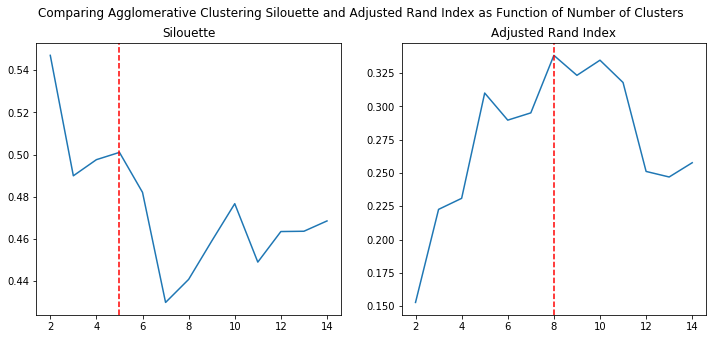

In [26]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
axes[0].plot(list(range(2,15)),silhouette_scores)
axes[0].axvline(5,0,1,ls='--',c='r')
axes[0].set_title('Silouette')
axes[1].plot(list(range(2,15)),adj_rand_scores)
axes[1].axvline(8,0,1,ls='--',c='r')
axes[1].set_title('Adjusted Rand Index')
fig.suptitle('Comparing Agglomerative Clustering Silouette and Adjusted Rand Index as Function of Number of Clusters',size=12)
plt.show()

Yikes. Silouette generally decreases with the number of clusters while adjusted Rand index increases. Ignoring the two cluster solution, which ofter has a high silouette score regardless of algorithm, 5 clusters maximizes silouette and 8 clusters maximizes adjusted Rand index. However, the Silouette score does appear to have located a "sweet spot," as the local maximum at n_clusters=5 coincides with a local maximum on the adjusted Rand index, something we wouldn't have access to if we were doing true unsupervised learning.

Curiously, agglomerative clustering has the lowest possible silouette score precisely the ground truth correct number of clusters, seven.

Let's plot the n_clusters=5 and n_clusters=8 results.

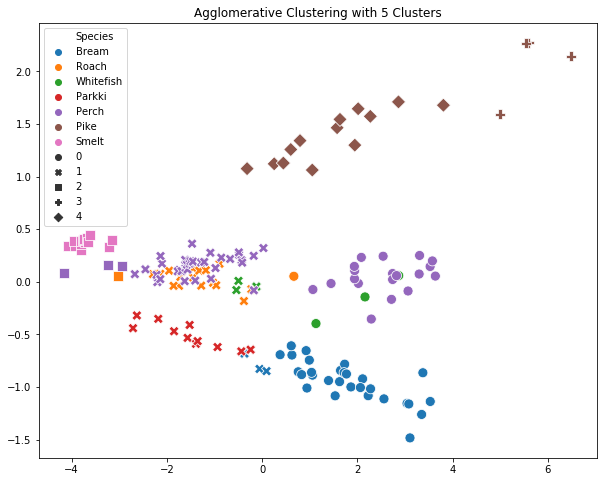

In [27]:
plt.figure(figsize=(10,8))
sns.scatterplot(X_std_pca[:,0],X_std_pca[:,1],hue=y,style=y_preds[3],s=100)
plt.title('Agglomerative Clustering with 5 Clusters')
plt.show()

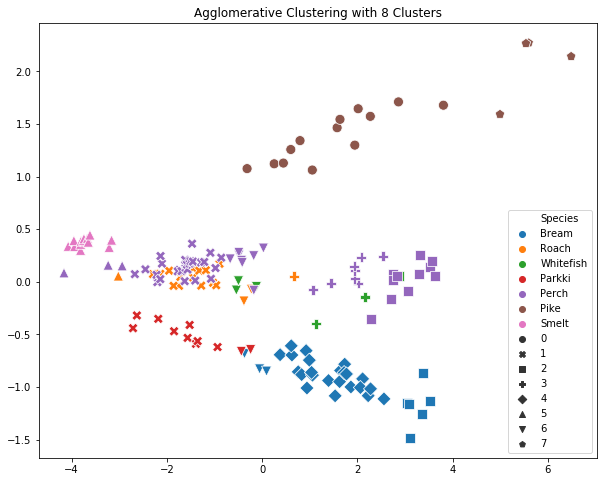

In [28]:
plt.figure(figsize=(10,8))
sns.scatterplot(X_std_pca[:,0],X_std_pca[:,1],hue=y,style=y_preds[6],s=100)
plt.title('Agglomerative Clustering with 8 Clusters')
plt.show()

Visually, going from 5 to 8 clusters did not help us, i.e., see clusters 6 and 2 in the 7 cluster solution.

#### Gaussian Mixture Model
I am optimistic about this algorithm. It assumes the data was built from a convex combination of Gaussian distributions which is plausible as our features are measurements like length and height.

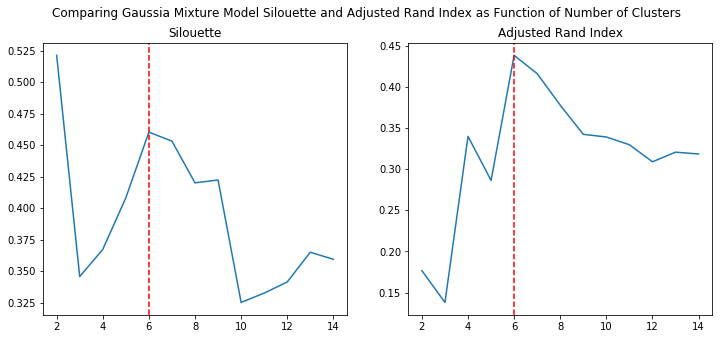

In [29]:
y_preds= []
# Compute clusters for n_clusters=2 to 15
for k in range(2,15):
    y_preds.append(GaussianMixture(n_components=k, random_state=123).fit_predict(X_std))
adj_rand_scores=[]
silhouette_scores=[]
for i in range(len(y_preds)):
    silhouette_scores.append(metrics.silhouette_score(X_std, y_preds[i], metric='euclidean'))   
    adj_rand_scores.append(metrics.adjusted_rand_score(y, y_preds[i]))

fig, axes = plt.subplots(1,2,figsize=(12,5))
axes[0].plot(list(range(2,15)),silhouette_scores)
axes[0].axvline(6,0,1,ls='--',c='r')
axes[0].set_title('Silouette')
axes[1].plot(list(range(2,15)),adj_rand_scores)
axes[1].axvline(6,0,1,ls='--',c='r')
axes[1].set_title('Adjusted Rand Index')
fig.suptitle('Comparing Gaussia Mixture Model Silouette and Adjusted Rand Index as Function of Number of Clusters',size=12)
plt.show()

This looks very promising. Once again ignoring the two cluster solution, the max of each score coincide with six clusters, very close to the ground truth. Furthermore, this is the highest adjusted Rand Index we've been able to achieve.

Let's plot the result.

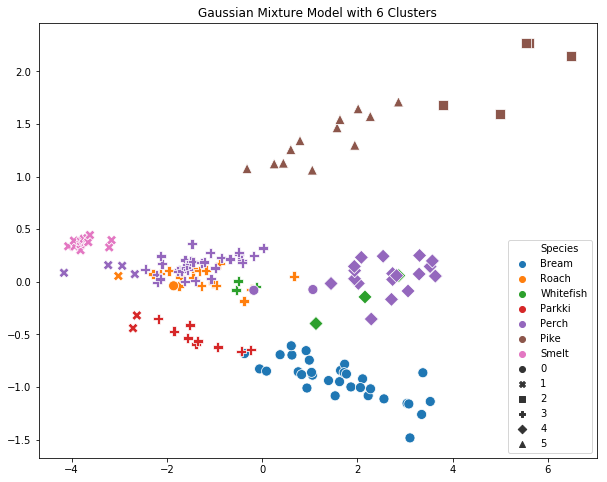

In [30]:
plt.figure(figsize=(10,8))
sns.scatterplot(X_std_pca[:,0],X_std_pca[:,1],hue=y,style=y_preds[4],s=100)
plt.title('Gaussian Mixture Model with 6 Clusters')
plt.show()

While far from perfect, this is the most visually satisfying result so far, and we've achieved a reasonable result for an unsupervised learning algorithm. Smelt and bream are well isolated. Pike is isolated too, though distributed between two clusters. Parkki are mostly confined to cluster 3, though this cluster extends out to capture roach and perch as well.